In [3]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision
from torchvision import transforms
# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
# openml.config.start_using_configuration_for_example()
warnings.simplefilter(action='ignore')

In [ ]:
import openml_pytorch as opt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

class IsotonicCalibrator:
    def __init__(self):
        self.iso_reg = None

    def fit(self, probs, true_labels):
        """
        Fits isotonic regression on the output probabilities and true labels.
        Args:
            probs (torch.Tensor): Predicted probabilities from the model.
            true_labels (torch.Tensor): True labels (ground truth).
        """
        self.iso_reg = IsotonicRegression(out_of_bounds='clip')
        calibrated_probs = np.zeros_like(probs.cpu())
        for class_idx in range(probs.shape[1]):
            prob = probs.cpu().numpy()
            t_labels = true_labels.cpu().numpy()

            # Fit isotonic regression for each class
            self.iso_reg.fit(prob[:, class_idx], (t_labels == class_idx).astype(int))
            calibrated_probs[:, class_idx] = self.iso_reg.transform(prob[:, class_idx])
        
        return torch.tensor(calibrated_probs, dtype=torch.float32).to(probs.device)

    def transform(self, probs):
        """
        Transforms the probabilities using the fitted isotonic regression.
        Args:
            probs (torch.Tensor): Probabilities to be calibrated.
        Returns:
            torch.Tensor: Calibrated probabilities.
        """
        if self.iso_reg is not None:
            prob = probs.cpu().numpy()
            calibrated_probs = np.zeros_like(prob)
            for class_idx in range(probs.shape[1]):
                calibrated_probs[:, class_idx] = self.iso_reg.transform(prob[:, class_idx])
            return torch.tensor(calibrated_probs, dtype=torch.float32).to(probs.device)
        else:
            raise ValueError("Isotonic Regression is not fitted yet.")

class CalibrationCallback:
    def __init__(self, calibrator, model):
        self.calibrator = calibrator
        self.model = model

    def on_validation_end(self, outputs, true_labels):
        """
        Call this method at the end of training to fit the calibrator.
        """
        print("IS calibrating")
        all_outputs = np.concatenate(outputs, axis=0)
        all_labels = np.concatenate(true_labels, axis=0)

        if all_labels.ndim == 1:  # If labels are integers (not one-hot encoded)
            num_classes = all_outputs.shape[1]  # Number of classes from model output
            all_labels_one_hot = np.eye(num_classes)[all_labels]  # Convert to one-hot encoding
        else:
            all_labels_one_hot = all_labels  # If already in one-hot encoded form

        auc = roc_auc_score(all_labels, all_outputs, multi_class='ovr', average='macro')
        print(f"Calibrated ROC AUC: {auc}")
        self.calibrator.fit(torch.tensor(all_outputs).to(device), torch.tensor(all_labels).to(device))
        self.model.set_calibrator(self.calibrator)


class CNET_HHD0(nn.Module):
    def __init__(self, num_classes=315, class_weights=None):
        super(CNET_HHD0, self).__init__()

        self.block1 = self._make_block(3, 128, pool_size=3)
        self.block2 = self._make_block(128, 256, pool_size=3)
        self.block3 = self._make_block(256, 512, pool_size=3)
        self.block4 = self._make_block(512, 1024, pool_size=3)
        self.fc1 = nn.Linear(50176, 1024)  
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(1024, num_classes)
        self.calibrator  = None
        self.class_weights = class_weights
        self.classes_ = None


    def _make_block(self, in_channels, out_channels, pool_size=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_size, stride=2),
        )

    def forward(self, x, targets=None):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        logits = self.fc2(x)
        probs = F.softmax(x, dim=1)

        if self.calibrator is not None:
            probs = self.calibrator.transform(probs)
        return probs
		
		
		
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.98),                         # Flip
    transforms.RandomHorizontalFlip(p=0.02),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.05),  # Random horizontal flip
    transforms.RandomAffine(degrees=2, translate=(0.1, 0.1)),  # Translation
    transforms.ToPILImage(),                       # Convert tensor to PIL Image
    transforms.Lambda(opt.trainer.convert_to_rgb), # Convert PIL Image to RGB if it's not already.
    transforms.ToTensor(),                         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize using imagenet values
])


data_module = opt.trainer.OpenMLDataModule(
    type_of_data="image",
    file_dir=str(data_dir),
    filename_col="file_path",
    target_mode="categorical",
    target_column="CATEGORY",
    batch_size=32,
    transform=transform
)


trainer = opt.trainer.OpenMLTrainerModule(
    experiment_name= "Assignment-3_P5_E2, CNET_HHD0",
    data_module=data_module,
    opt = torch.optim.Adam,
    opt_kwargs= {"lr": 0.0001},
    verbose=True,
    epoch_count=1,
    metrics= [opt.metrics.accuracy],
    loss_fn= torch.nn.CrossEntropyLoss,
    callbacks=[],
)
# DO NOT REMOVE THIS LINE
opt.config.trainer = trainer



task = openml.tasks.get_task(363465)
num_classes = len(task.class_labels)
labels = get_training_labels(task)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = compute_class_weights(labels, num_classes, device)



# Add your API key here. You can remove it afterward.
openml.config.apikey = '6dfad4b14b0368a46cc1f4d6ac6b2777'

def evaluate_model_and_publish_results(model, trainer):
    task = openml.tasks.get_task(363465)   # Get data and crossvalidation splits
    num_classes = len(task.class_labels)   # Sets the correct number of classes
      
    # Step 1: Load training labels and compute class weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    labels = get_training_labels(task)
    weights = compute_class_weights(labels, num_classes, device)

    model = create_model(num_classes, weights)
    print("Training model...")
    run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=True)
    run.publish()
    print("Run is uploaded at https://www.openml.org/r/{}".format(run.run_id))

# Basic Image classification task

In [1]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision
from torchvision import transforms
# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
# openml.config.start_using_configuration_for_example()
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [2]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((32, 32)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
transform_test = Compose(
    [
        transforms.RandomRotation(degrees=5),
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((32, 32)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)

### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [3]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=32,
    transform=transform,
    transform_test = transform_test
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(363295)


In [4]:
task

OpenML Classification Task
Task Type Description: https://www.openml.org/tt/TaskType.SUPERVISED_CLASSIFICATION
Task ID..............: 363295
Task URL.............: https://www.openml.org/t/363295
Estimation Procedure.: crossvalidation
Evaluation Measure...: predictive_accuracy
Target Feature.......: label
# of Classes.........: 200
Cost Matrix..........: Available

## Model

In [5]:
model = torchvision.models.resnet18(num_classes=200)

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [6]:
import torch


trainer = OpenMLTrainerModule(
    experiment_name= "Testing model upload",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        # TestCallback,
    ],
    opt=torch.optim.Adam,
    loss_fn = torch.nn.CrossEntropyLoss
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

Cross validation 0 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4578 | accuracy: 0.0127 | other metrics: []
Valid: valid loss: 5.2857 | accuracy: 0.0167 | other metrics: []

Loss tensor(5.2475, device='mps:0')
Cross validation 1 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4561 | accuracy: 0.0120 | other metrics: []
Valid: valid loss: 5.2785 | accuracy: 0.0167 | other metrics: []

Loss tensor(5.2771, device='mps:0')
Cross validation 2 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4571 | accuracy: 0.0086 | other metrics: []
Valid: valid loss: 5.3153 | accuracy: 0.0083 | other metrics: []

Loss tensor(5.3036, device='mps:0')
Cross validation 3 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4576 | accuracy: 0.0105 | other metrics: []
Valid: valid loss: 5.2835 | accuracy: 0.0111 | other metrics: []

Loss tensor(5.3474, device='mps:0')
Cross validation 4 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4583 | accuracy: 0.0090 | other metrics: []
Valid: valid loss: 5.3000 | accuracy: 0.0111 | other metrics: []

Loss tensor(5.3468, device='mps:0')
Cross validation 5 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4602 | accuracy: 0.0099 | other metrics: []
Valid: valid loss: 5.2782 | accuracy: 0.0167 | other metrics: []

Loss tensor(5.3153, device='mps:0')
Cross validation 6 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4649 | accuracy: 0.0096 | other metrics: []
Valid: valid loss: 5.2280 | accuracy: 0.0028 | other metrics: []

Loss tensor(5.2645, device='mps:0')
Cross validation 7 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4767 | accuracy: 0.0093 | other metrics: []
Valid: valid loss: 5.2870 | accuracy: 0.0167 | other metrics: []

Loss tensor(5.2919, device='mps:0')
Cross validation 8 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4332 | accuracy: 0.0096 | other metrics: []
Valid: valid loss: 5.2400 | accuracy: 0.0222 | other metrics: []

Loss tensor(5.2886, device='mps:0')
Cross validation 9 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4535 | accuracy: 0.0086 | other metrics: []
Valid: valid loss: 5.2410 | accuracy: 0.0194 | other metrics: []

Loss tensor(5.2032, device='mps:0')


In [ ]:
openml.config.apikey = ""

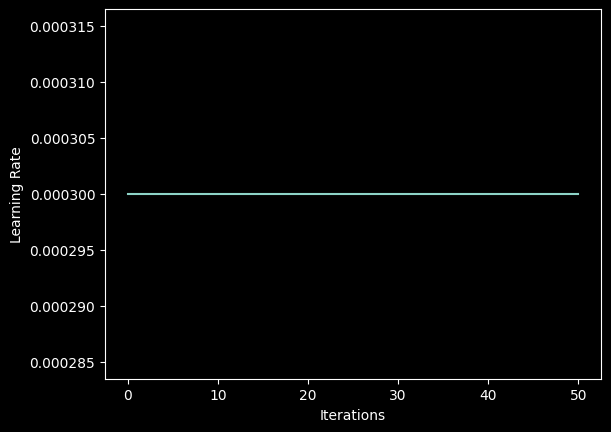

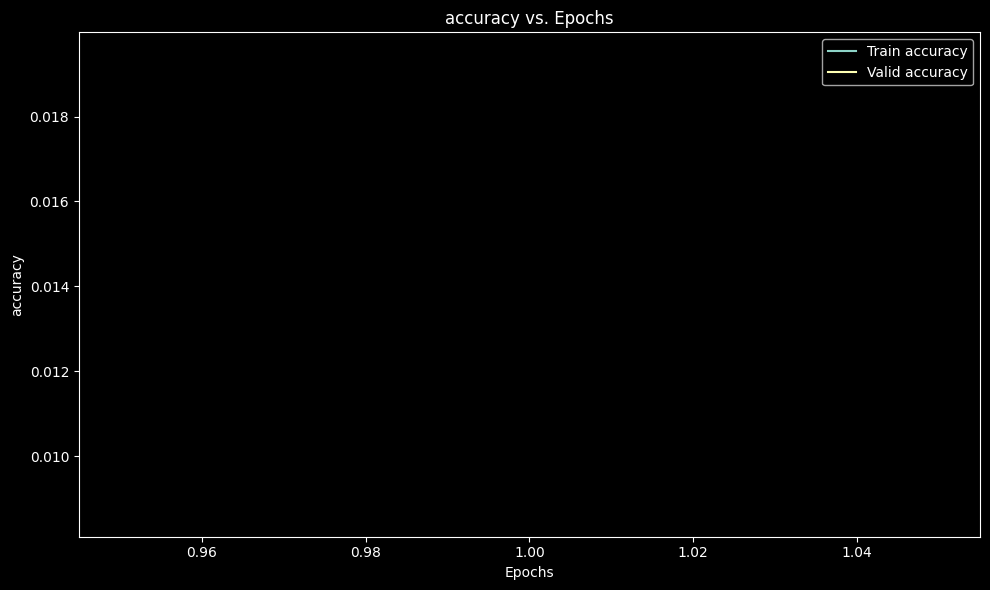

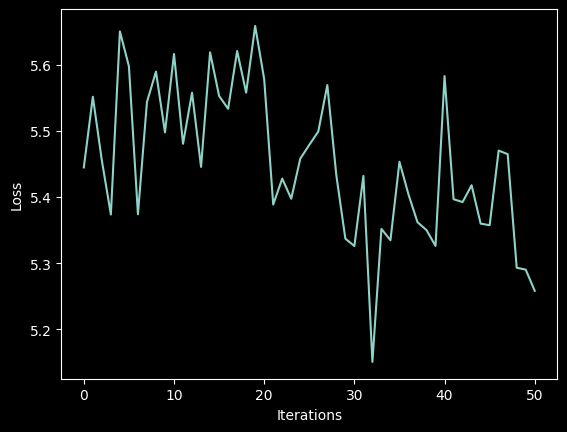

In [9]:
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer, upload_model=True)

In [10]:
run.publish()

OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.0145 +- 0.0060
Run ID..........................: 10595300
Run URL.........................: https://www.openml.org/r/10595300
Task ID.........................: 363295
Task Type.......................: None
Task URL........................: https://www.openml.org/t/363295
Flow ID.........................: 29313
Flow Name.......................: torch.nn.ResNet.5556557a1efbdb52
Flow URL........................: https://www.openml.org/f/29313
Setup ID........................: None
Setup String....................: Python_3.13.2. Torch_2.6.0. NumPy_2.2.4. SciPy_1.15.2. ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

In [11]:
trainer.stats.metrics

{}

In [12]:
trainer.plot_all_metrics()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

<module 'matplotlib.pyplot' from '/Users/smukherjee/Documents/CODE/Github/OpenML/openml-pytorch/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

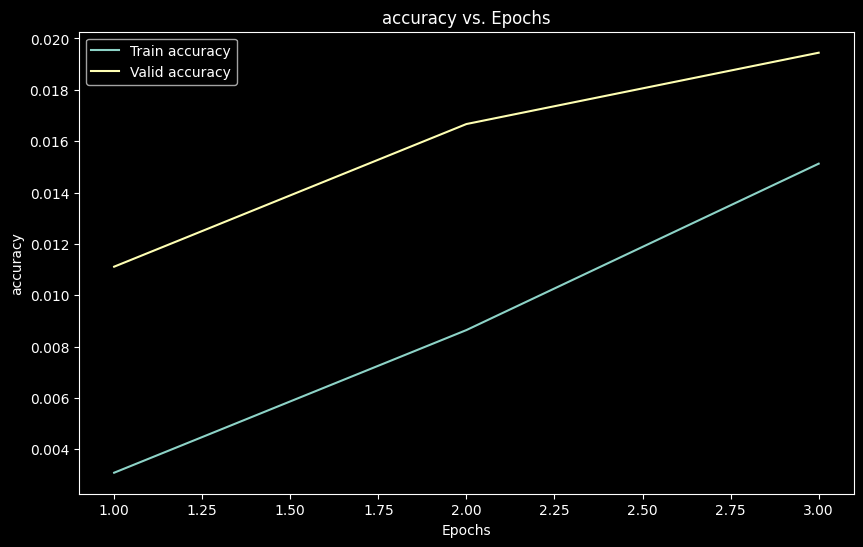

In [9]:
trainer.runner.cbs[1].plot_metric('accuracy')

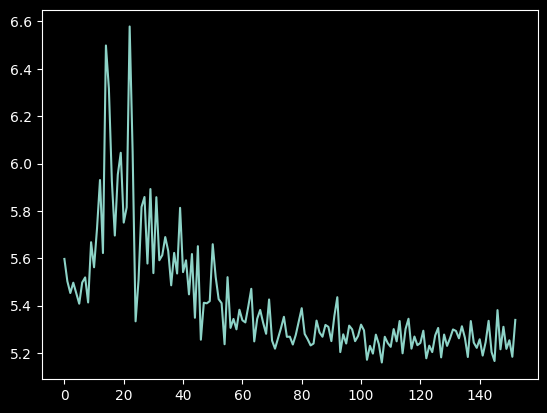

In [13]:
trainer.plot_loss()

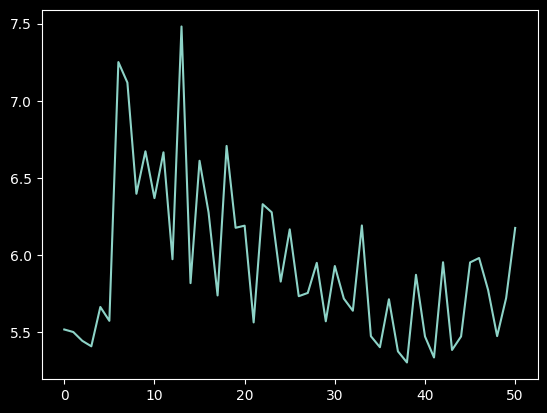

In [22]:
trainer.plot_loss()

## testing push


In [9]:
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer)

In [ ]:
run.publish()

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

In [ ]:
trainer.cbfs

In [ ]:
trainer.experiment_name

In [ ]:
trainer.model

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
run.publish()

# Pretrained Transformer Image Classification Task

In [ ]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [ ]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [ ]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)


## Model

In [ ]:
# Example model. You can do better :)
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained model
model = models.efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to the required number of classes
num_classes = 200
in_features = model.classifier[-1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes),
)

# Optional: If you're fine-tuning, you may want to freeze the pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # If you want to train the last layer only (the newly added layer)
# for param in model.fc.parameters():
#     param.requires_grad = True

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:


trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Choose a custom Optimizer
- If you want to use a custom optimizer, you can do so by defining the optimizer in the `optimizer` variable.

In [1]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [2]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [3]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)


## Model

In [4]:
model = torchvision.models.resnet18(num_classes=200)

## Train your model on the data
- Choose a custom optimizer by defining the optimizer variable.
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [5]:
import torch
from torch.optim import Adam, Optimizer
from openml_pytorch.trainer import OpenMLTask

def custom_optimizer_gen(model: torch.nn.Module, task: OpenMLTask) -> Optimizer:
    # replace the optimizer with your own
    return Adam(model.fc.parameters())


In [ ]:
trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
    optimizer = custom_optimizer_gen,
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Sequential Classification Task
- Sequential classification of a tabular MNIST dataset (Task 3573) using a simple neural network.

In [4]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [5]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    filename_col="class",
    target_mode="categorical",
)

# Download the OpenML task for the mnist 784 dataset.
task = openml.tasks.get_task(3573)

## Model

In [6]:

############################################################################
# Define a sequential network that does the initial image reshaping
# and normalization model.
processing_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 1, 28, 28)),
    torch.nn.BatchNorm2d(num_features=1)
)
############################################################################

############################################################################
# Define a sequential network that does the extracts the features from the
# image.
features_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)
############################################################################

############################################################################
# Define a sequential network that flattens the features and compiles the
# results into probabilities for each digit.
results_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 4 * 4 * 64)),
    torch.nn.Linear(in_features=4 * 4 * 64, out_features=256),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=10),
)
############################################################################
# openml.config.apikey = 'key'

############################################################################
# The main network, composed of the above specified networks.
model = torch.nn.Sequential(
    processing_net,
    features_net,
    results_net
)
############################################################################


## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:
trainer = OpenMLTrainerModule(
    experiment_name= "MNIST",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Tabular classification
- Supervised credit-g classification

In [19]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [20]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    target_column="class",
    target_mode="categorical",
)

# supervised credit-g classification
task = openml.tasks.get_task(31)


## Model

In [21]:
class TabularClassificationmodel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularClassificationmodel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
model = TabularClassificationmodel(20, 2)

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:


trainer = OpenMLTrainerModule(
    experiment_name= "Credit-G",
    data_module=data_module,
    verbose=True,
    epoch_count=5,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()